In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch
import matplotlib
#from sklearn import preprocessing

import preprocessing
import train

In [2]:
%load_ext autoreload
%autoreload 2

#### more data

In [3]:
S_data_2019_04_14 = preprocessing.Preprocessing('S_data_2019_04_14','/Users/cm/20190414/','home-assistant_v2.db')

In [4]:
rooms = ['schlafzimmer','kuche','wohnzimmer','bad']

In [5]:
S_data_2019_04_14.load_data(rooms=rooms)

#### Extract weather data

In [6]:
S_data_2019_04_14.extract_weather_data()

#### Build X Frames weather data

In [7]:
S_data_2019_04_14.build_x_frame(rooms=rooms)

#### Test with one specific DataFrame

In [10]:
wohnzimmer = S_data_2019_04_14.get('train_climatewohnzimmer')
kueche = S_data_2019_04_14.get('train_climatekuche')
schlafzimmer = S_data_2019_04_14.get('train_climateschlafzimmer')

In [11]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler()

In [20]:
end_date = np.datetime64('2020-04-08 23:59:00')
start_date = np.datetime64('2019-04-03 00:00:00')

In [21]:
frame3 = wohnzimmer_sel = wohnzimmer[(wohnzimmer['last_updated'] > start_date) & (wohnzimmer['last_updated'] < end_date)]
frame4 = min_max_scaler.fit_transform(wohnzimmer_sel.drop(columns=['last_updated','current_temp','day','month', 'year','symbol']).astype(np.float64)).astype(np.float32)

In [22]:
wohnzimmer_sel.columns

Index(['last_updated', 'current_temp', 'set_temp', 'weather_temperature',
       'symbol', 'precipitation', 'wind_speed', 'pressure', 'wind_direction',
       'humidity', 'cloudiness', 'low_clouds', 'medium_clouds', 'high_clouds',
       'dewpoint_temperature', 'day', 'month', 'year'],
      dtype='object')

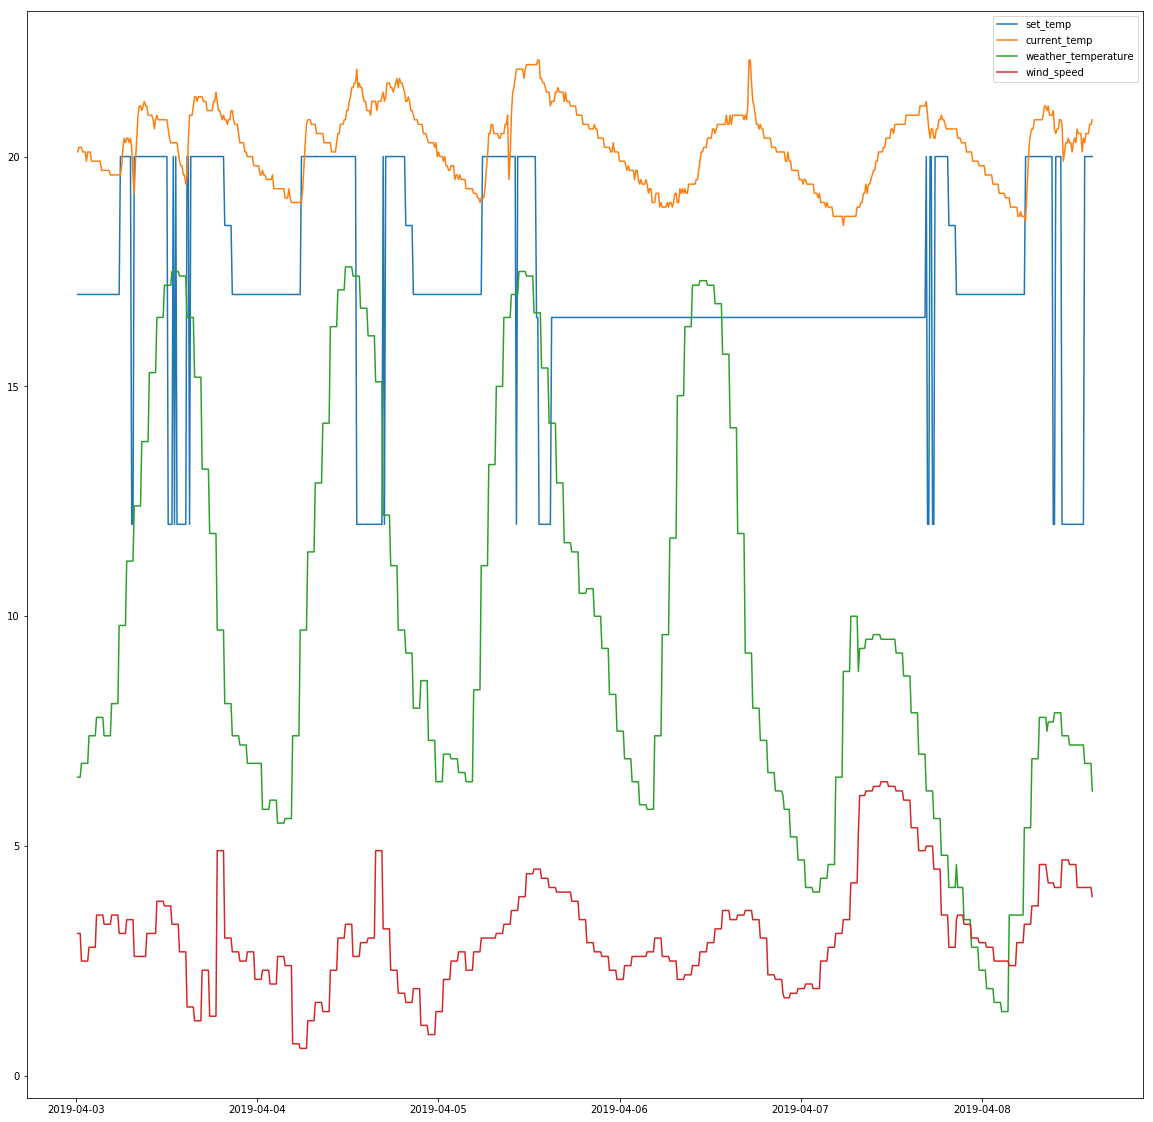

In [23]:
dates = matplotlib.dates.date2num(wohnzimmer_sel['last_updated']);
fig1 = matplotlib.pyplot.figure(figsize=[20,20]);
plt.plot_date(dates, wohnzimmer_sel['set_temp'], '-');
plt.plot_date(dates, wohnzimmer_sel['current_temp'], '-');
plt.plot_date(dates, wohnzimmer_sel['weather_temperature'], '-');
matplotlib.pyplot.plot_date(dates, wohnzimmer_sel['wind_speed'], '-');
plt.legend();

In [24]:
frame3 = kueche_sel = kueche[(kueche['last_updated'] > start_date) & (kueche['last_updated'] < end_date)]
frame4 = min_max_scaler.fit_transform(kueche_sel.drop(columns=['last_updated','current_temp','day','month', 'year','symbol']).astype(np.float64)).astype(np.float32)

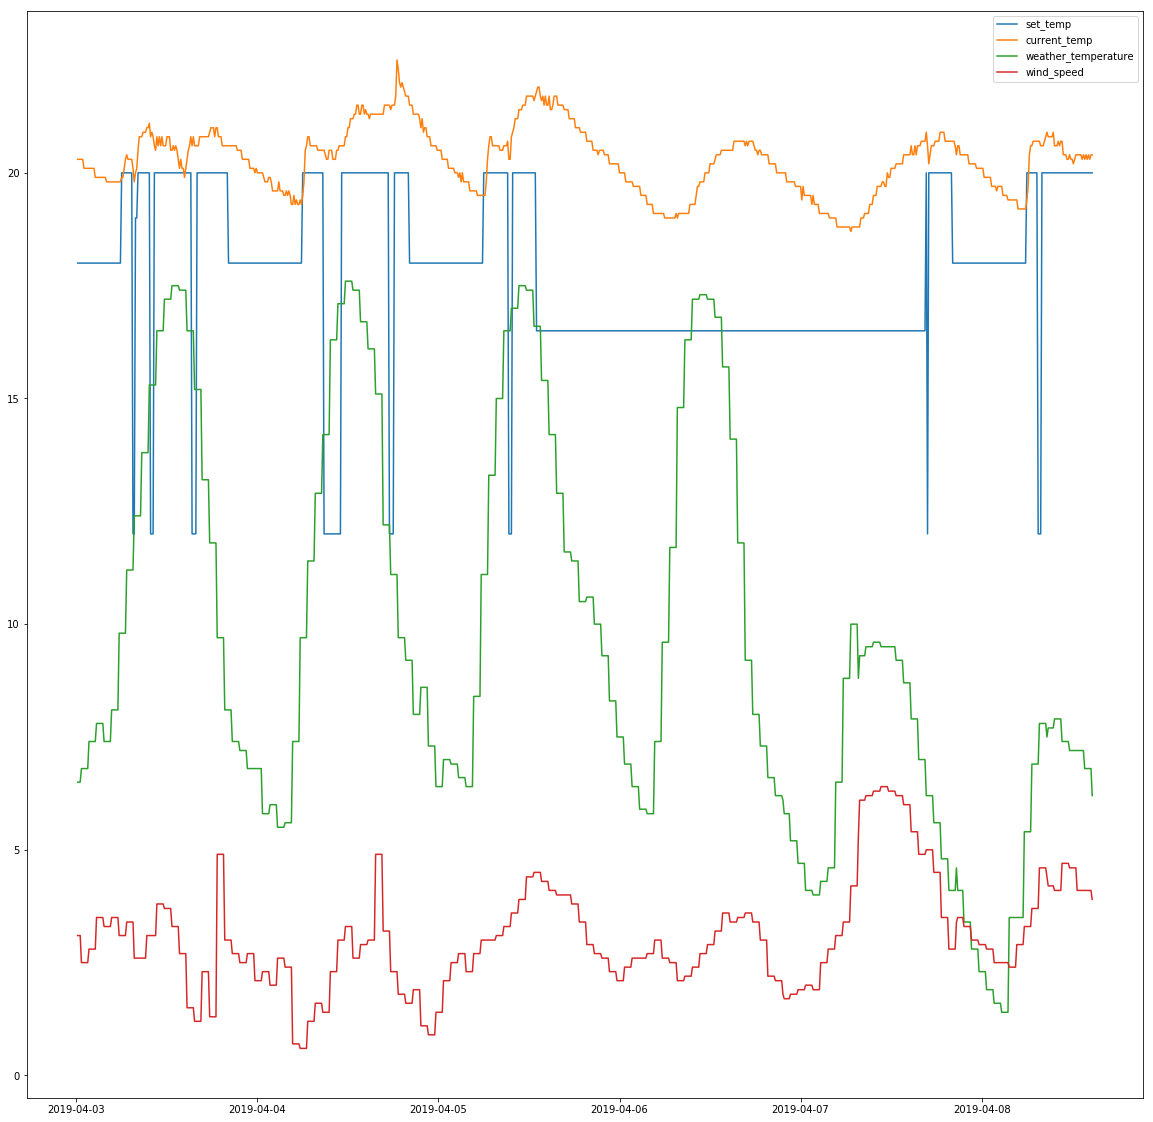

In [25]:
dates = matplotlib.dates.date2num(kueche_sel['last_updated']);
fig1 = matplotlib.pyplot.figure(figsize=[20,20]);
plt.plot_date(dates, kueche_sel['set_temp'], '-');
plt.plot_date(dates, kueche_sel['current_temp'], '-');
plt.plot_date(dates, kueche_sel['weather_temperature'], '-');
matplotlib.pyplot.plot_date(dates, kueche_sel['wind_speed'], '-');
plt.legend();

In [26]:
frame3 = schlafzimmer_sel = schlafzimmer[(schlafzimmer['last_updated'] > start_date) & (schlafzimmer['last_updated'] < end_date)]
frame4 = min_max_scaler.fit_transform(schlafzimmer_sel.drop(columns=['last_updated','current_temp','day','month', 'year','symbol']).astype(np.float64)).astype(np.float32)

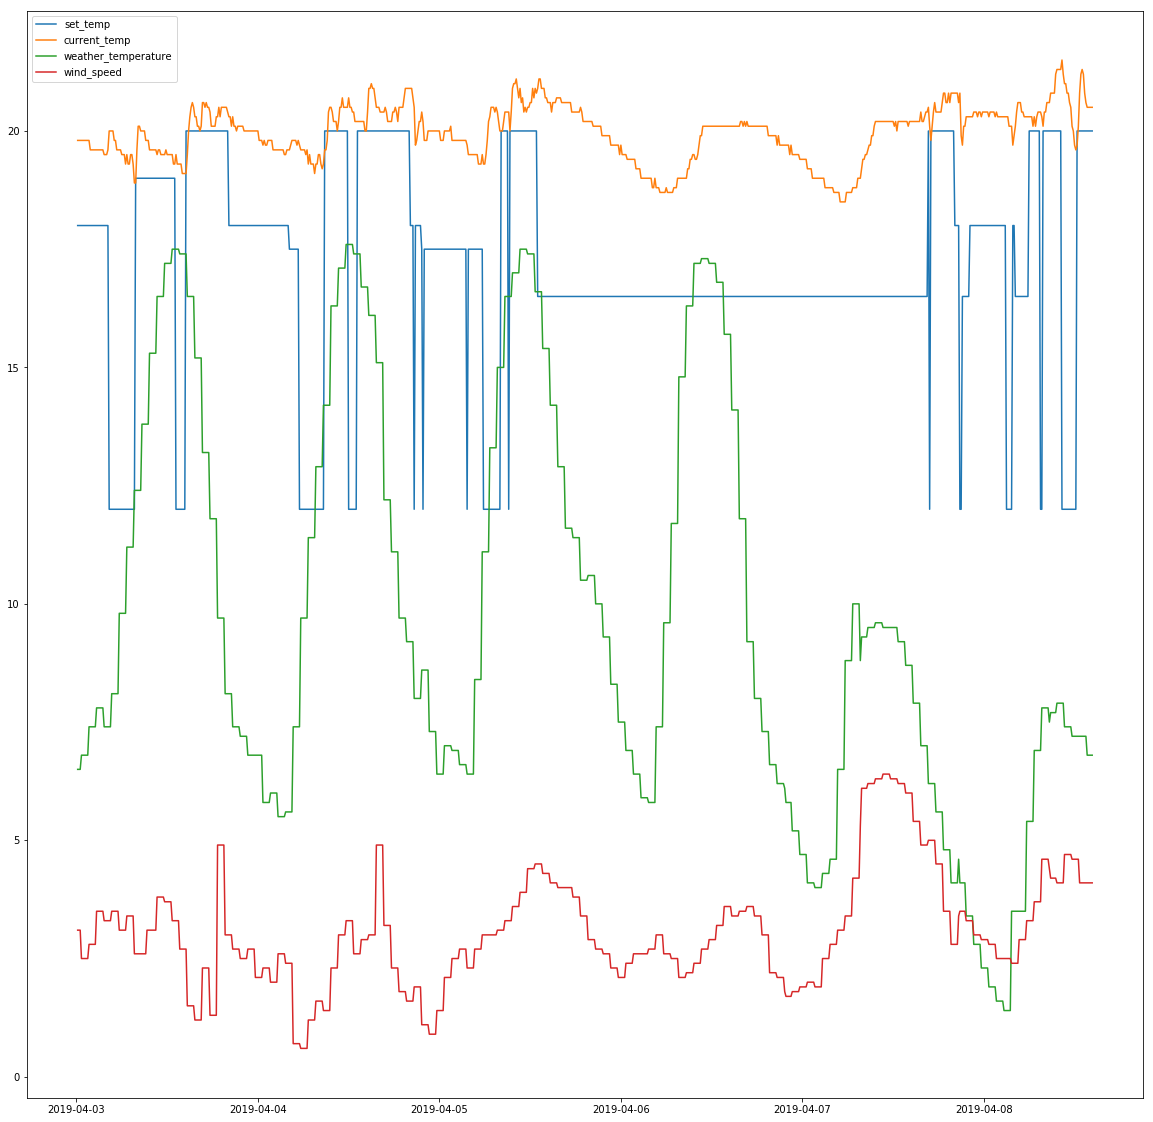

In [27]:
dates = matplotlib.dates.date2num(schlafzimmer_sel['last_updated']);
fig1 = matplotlib.pyplot.figure(figsize=[20,20]);
plt.plot_date(dates, schlafzimmer_sel['set_temp'], '-');
plt.plot_date(dates, schlafzimmer_sel['current_temp'], '-');
plt.plot_date(dates, schlafzimmer_sel['weather_temperature'], '-');
matplotlib.pyplot.plot_date(dates, schlafzimmer_sel['wind_speed'], '-');
plt.legend();

In [101]:
wohnzimmer_sel.columns#.drop(columns=['last_updated', 'day','month', 'year'])

Index(['last_updated', 'current_temp', 'set_temp', 'weather_temperature',
       'symbol', 'precipitation', 'wind_speed', 'pressure', 'wind_direction',
       'humidity', 'cloudiness', 'low_clouds', 'medium_clouds', 'high_clouds',
       'dewpoint_temperature', 'day', 'month', 'year'],
      dtype='object')

In [202]:
train_set, val_set, test_set = train.train_val_test_split(wohnzimmer_sel, 143,0.2, 0.1)

(429, 18) (143, 18) (143, 18)


In [203]:
trainset_df = pd.DataFrame(train_set.reshape(train_set.shape[0]*train_set.shape[1],train_set.shape[2]))#.sample(frac=1439).reset_index(drop=True)
valset_df = pd.DataFrame(val_set.reshape(val_set.shape[0]*val_set.shape[1],val_set.shape[2]))#.sample(frac=1439).reset_index(drop=True)
testset_df = pd.DataFrame(test_set.reshape(test_set.shape[0]*test_set.shape[1],test_set.shape[2]))

In [204]:
X_train = trainset_df.drop(columns=[0])
y_train = trainset_df[0]
X_val = valset_df.drop(columns=[0])
y_val = valset_df[0]
X_test = testset_df.drop(columns=[0])
y_test = testset_df[0]

In [205]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler()

In [106]:
min_max_scaler.fit(X_train.astype(np.float64))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [107]:
X_train = min_max_scaler.transform(X_train).astype(np.float32)
X_val= min_max_scaler.transform(X_val).astype(np.float32)

In [108]:
X_train.shape

(429, 12)

In [109]:
from sklearn.neighbors import KNeighborsRegressor

In [110]:
X_train.shape

(429, 12)

In [111]:
train_errors = []
test_errors = []
train_errors_val = []

for k in range(1,10):
    knn_iterated = KNeighborsRegressor(k)
    # Training
    knn_iterated.fit(X_train, y_train)
    
    # Predict
    y_k_predict = knn_iterated.predict(X_train)
    train_errors.append((1.0 * (y_train - y_k_predict)).mean())
                        
    y_k_predict_val = knn_iterated.predict(X_val)
    train_errors_val.append((1.0 * (y_val - y_k_predict_val)).mean())

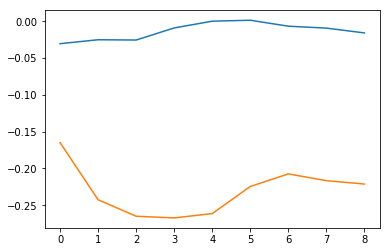

In [112]:
matplotlib.pyplot.plot(train_errors)
matplotlib.pyplot.plot(train_errors_val);

In [153]:
knn = sklearn.neighbors.KNeighborsRegressor(2)
knn.fit(X_train, y_train)
y_k_predict = knn.predict(X_train)

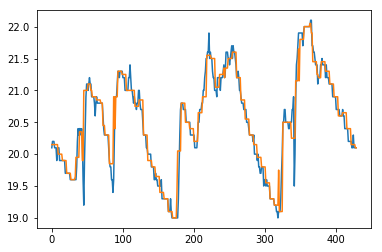

In [154]:
matplotlib.pyplot.plot(list(y_train));
matplotlib.pyplot.plot(y_k_predict.reshape(y_k_predict.shape[0]));

In [115]:
D_in = X_train.shape[1]
D_out = 1
N = X_train.shape[0]

In [116]:
# Zufällige initialisierung der Gewichte
w = np.random.randn(D_in, D_out)

In [117]:
learning_rate = 1e-3

In [118]:
loss_hist = []
loss_hist_val = []
# Train
for t in range(300):
    # Berechne die Vorhersage
    y_pred = X_train.dot(w)
    y_pred_val = X_val.dot(w)
    y_pred = y_pred.reshape(y_pred.shape[0])
    y_pred_val = y_pred_val.reshape(y_pred_val.shape[0])
    # Berechne den Fehler (Ausgabe des Fehlers alle 100 Iterationen)
    loss = np.square(y_pred - y_train).sum()
    loss_val = np.square(y_pred_val - y_val).sum()
    if t % 2 == 0:
        loss_hist.append(loss)
        loss_hist_val.append(loss_val)
        print(t, loss)

    # Berechne die Gradienten von w1 im Bezug auf den Fehler 
    grad_y_pred = 2.0 * (y_pred - y_train)
    grad_w = (1/N) * X_train.T.dot(grad_y_pred)

    # Aktualisiere die Gewichte mittels Gradienten Abstieg
    w -= learning_rate * grad_w.sum()

0 136232.8955171472
2 108872.40711447454
4 87156.3171296936
6 69920.20068006776
8 56239.85074261288
10 45381.721827193265
12 36763.59699245638
14 29923.36915526103
16 24494.262735712353
18 20185.1670131245
20 16765.026660088566
22 14050.452469232612
24 11895.88795520028
26 10185.804561361023
28 8828.50697531116
30 7751.216391861431
32 6896.168086230078
34 6217.514047853662
36 5678.864592879838
38 5251.337135682762
40 4912.007493798542
42 4642.680684671061
44 4428.915303869051
46 4259.2491715687975
48 4124.58472617673
50 4017.7012096676044
52 3932.8674878333386
54 3865.534744719118
56 3812.0925734073035
58 3769.6753846455676
60 3736.008752877352
62 3709.287460691222
64 3688.0787023867856
66 3671.24525639612
68 3657.8845070371453
70 3647.2800459225086
72 3638.8632578733946
74 3632.182831560553
76 3626.88056002171
78 3622.672133470011
80 3619.3318944967127
82 3616.6807382363713
84 3614.576508696822
86 3612.9063763016375
88 3611.5807879259264
90 3610.5286650242406
92 3609.6935923723277
94 

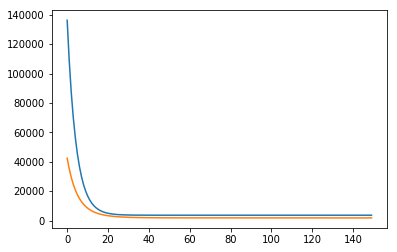

In [119]:
matplotlib.pyplot.plot(loss_hist)
matplotlib.pyplot.plot(loss_hist_val);

In [120]:
len(list(y_pred.reshape(y_pred.shape[0])))

429

In [121]:
sklearn.metrics.mean_squared_error(list(y_train), list(y_pred.reshape(y_pred.shape[0])))

8.406715055428544

In [122]:
len(list(y_train))

429

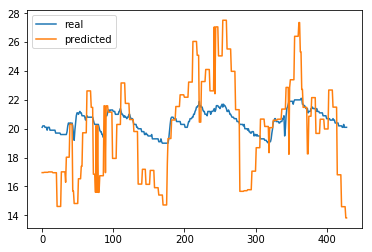

In [123]:
matplotlib.pyplot.plot(list(y_train))
matplotlib.pyplot.plot(list(y_pred));
matplotlib.pyplot.legend(['real','predicted'])

In [124]:
#error = 
error = list(np.array(list(y_train)) - np.array(list(y_pred.reshape(y_pred.shape[0]))))

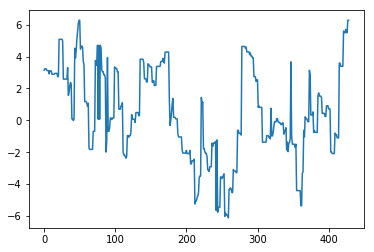

In [125]:
matplotlib.pyplot.plot(error);

In [126]:
y_train.shape

(429,)

In [127]:
X_train.shape

(429, 12)

In [128]:
frame4.shape

(806, 12)

In [163]:
knn = sklearn.neighbors.KNeighborsRegressor(2)
knn.fit(X_train, y_train)
y_k_predict = knn.predict(frame4)
len(y_k_predict)

806

In [164]:
len(frame4[:,1])

806

In [165]:
(y_k_predict-frame3['current_temp']).mean()

0.42897022332506174

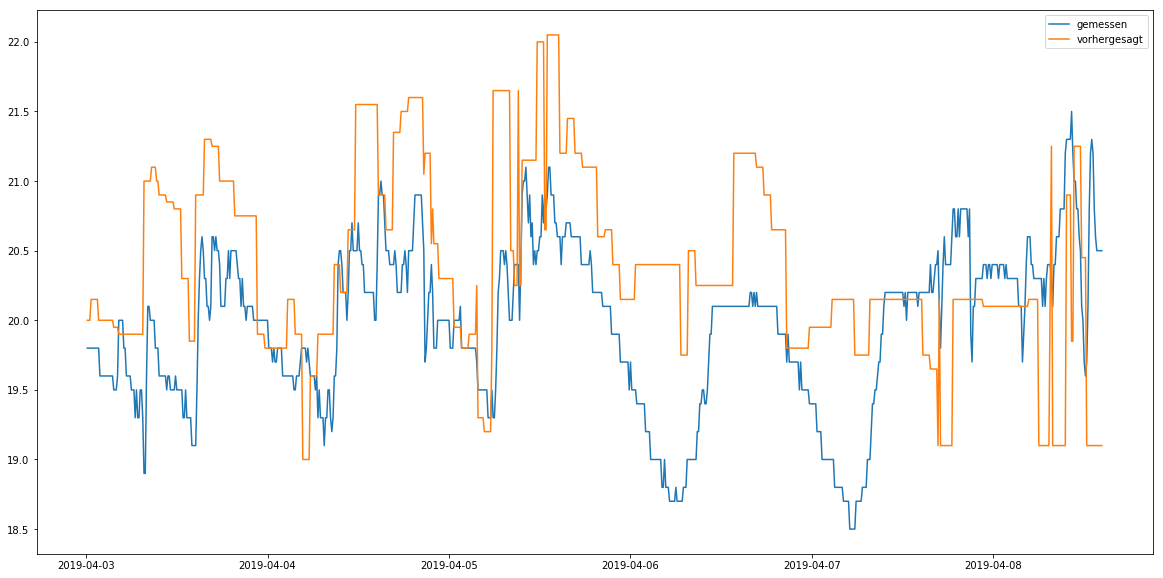

In [166]:
dates = matplotlib.dates.date2num(frame3['last_updated'])
fig1 = matplotlib.pyplot.figure(figsize=[20,10])
matplotlib.pyplot.plot_date(dates,list(frame3['current_temp']),'-')
matplotlib.pyplot.plot_date(dates,y_k_predict.reshape(y_k_predict.shape[0]),'-')
matplotlib.pyplot.legend(['gemessen','vorhergesagt']);

In [167]:
from sklearn.tree import DecisionTreeRegressor

In [168]:
# Train the model using the training sets
error = []
error_val = []
error_test = []
probilities = pd.DataFrame()
proba_test = []
proba_train = []
proba_validate = []

for i in range(1, 150):
#Predict Output
    classifier = DecisionTreeRegressor(max_depth = i)
    classifier.fit(X_train,y_train)
    y_= classifier.predict(X_train)
    y_v = classifier.predict(X_val)
    y_t = classifier.predict(X_test)
    error.append(sklearn.metrics.mean_squared_error(y_train,y_))
    error_test.append(sklearn.metrics.mean_squared_error(y_test,y_t))
    error_val.append(sklearn.metrics.mean_squared_error(y_val,y_v))

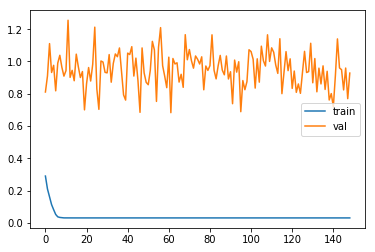

In [169]:
matplotlib.pyplot.plot(error)
matplotlib.pyplot.plot(error_val)
#matplotlib.pyplot.plot(error_test)
matplotlib.pyplot.legend(['train','val','test']);

In [170]:
y_t_1 = classifier.predict(X_test)

In [194]:
dtr = DecisionTreeRegressor(max_depth=95)
dtr.fit(X_train, y_train)
y_dtr_predict = dtr.predict(frame4)

In [195]:
(y_dtr_predict-frame3['current_temp']).mean()

0.8217452440033077

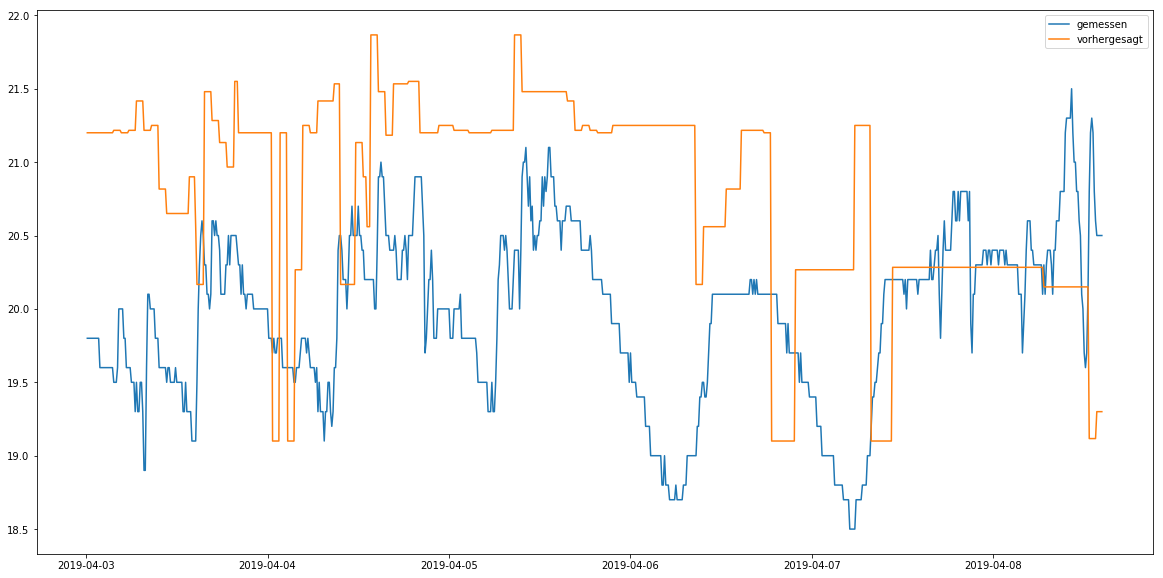

In [196]:
dates = matplotlib.dates.date2num(frame3['last_updated'])
fig1 = matplotlib.pyplot.figure(figsize=[20,10])
matplotlib.pyplot.plot_date(dates,list(frame3['current_temp']),'-')
matplotlib.pyplot.plot_date(dates,y_dtr_predict,'-')
matplotlib.pyplot.legend(['gemessen','vorhergesagt']);

In [178]:
from sklearn.ensemble import RandomForestRegressor

In [141]:
error_train = []
error_val = []

for i in range(1, 100):
    #for j in range(1,5):
        #for k in range(2,10):
    d_forest = RandomForestRegressor(n_estimators=i, n_jobs=-1, random_state=42)
    d_forest.fit(X_train, y_train)
    y_pred_train = d_forest.predict(X_train)
    y_pred_val = d_forest.predict(X_val)
    error_train.append(sklearn.metrics.mean_squared_error(y_train, y_pred_train))
    error_val.append(sklearn.metrics.mean_squared_error(y_val, y_pred_val))

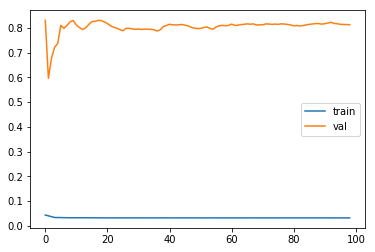

In [142]:
matplotlib.pyplot.plot(error_train)
matplotlib.pyplot.plot(error_val)
matplotlib.pyplot.legend(['train','val']);

In [197]:
fr = RandomForestRegressor(n_estimators=2, n_jobs=-1)
fr.fit(X_train, y_train)
y_fr_predict = fr.predict(frame4)

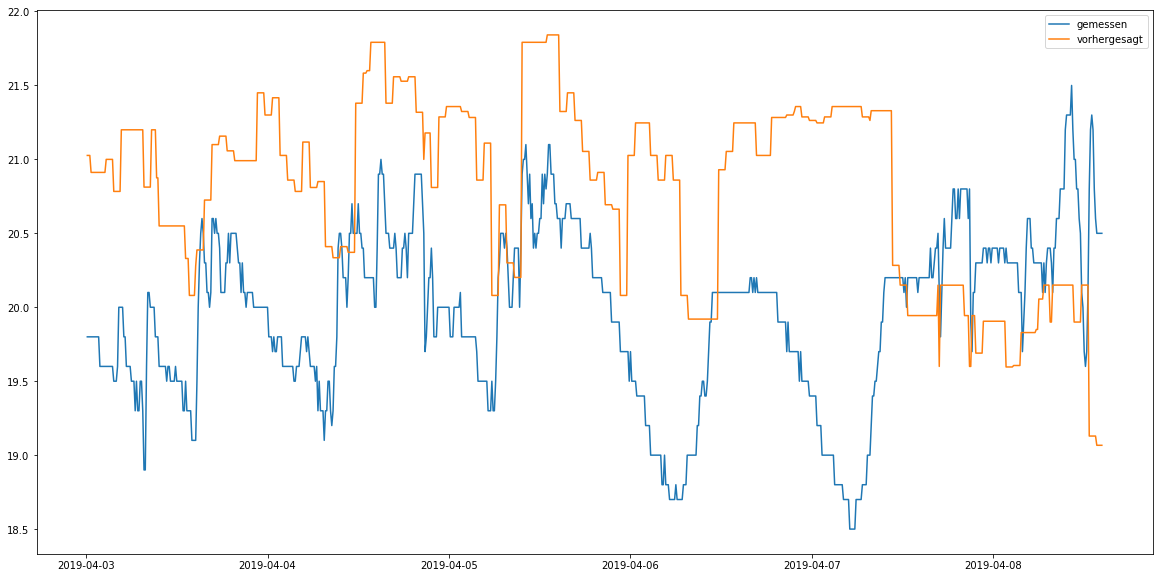

In [198]:
dates = matplotlib.dates.date2num(frame3['last_updated'])
fig1 = matplotlib.pyplot.figure(figsize=[20,10])
matplotlib.pyplot.plot_date(dates,list(frame3['current_temp']),'-')
matplotlib.pyplot.plot_date(dates,y_fr_predict,'-')
matplotlib.pyplot.legend(['gemessen','vorhergesagt']);

In [145]:
(y_fr_predict-frame3['current_temp']).mean()

0.7464595987569771

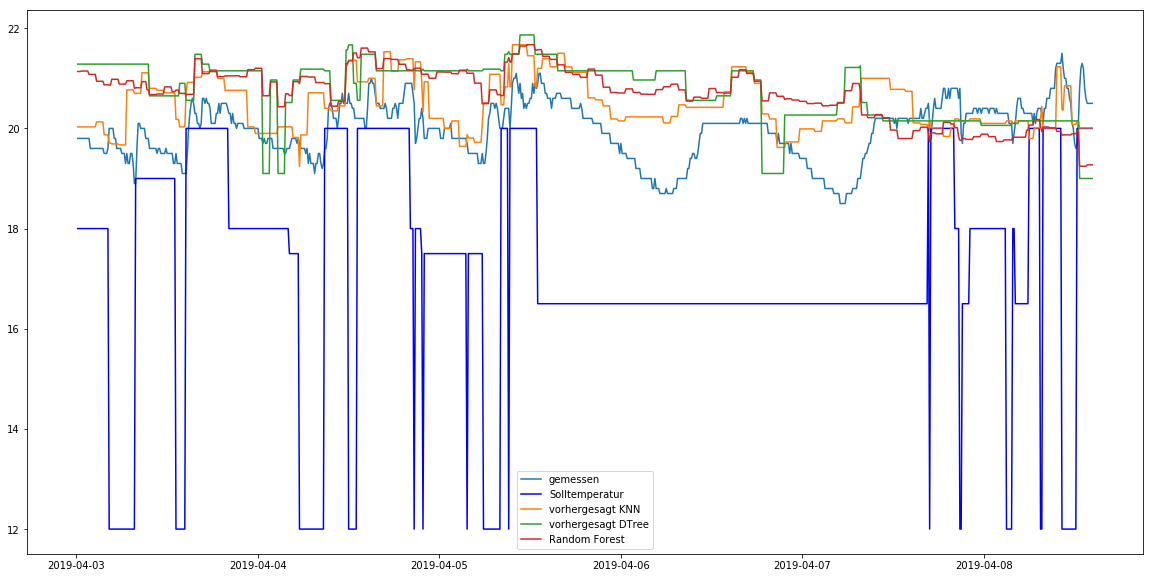

In [146]:
dates = matplotlib.dates.date2num(frame3['last_updated'])
fig1 = matplotlib.pyplot.figure(figsize=[20,10])
matplotlib.pyplot.plot_date(dates,list(frame3['current_temp']),'-')
matplotlib.pyplot.plot_date(dates, frame3['set_temp'], 'b-')
matplotlib.pyplot.plot_date(dates,y_k_predict.reshape(y_k_predict.shape[0]),'-')
matplotlib.pyplot.plot_date(dates,y_dtr_predict,'-')
matplotlib.pyplot.plot_date(dates,y_fr_predict,'-')
matplotlib.pyplot.legend(['gemessen', 'Solltemperatur', 'vorhergesagt KNN', 'vorhergesagt DTree', 'Random Forest']);